In [55]:
#If your input at different folder please chnage here
import os.path
import sys,traceback

def main(filename):
    if os.path.isfile(filename) == False :
        #filename='/home/jovyan/input/yelp_dataset.tar'
        print("Something wrong in input file. Please give correct input file")
    else :
        print(filename)
        !mkdir -p ~/input
        !tar -xvf {filename} -C ~/input

In [ ]:
main('/home/jovyan/input/yelp_dataset.tar')



/home/jovyan/input/yelp_dataset.tar
business.json
checkin.json
review.json


In [53]:
# import necessary libraries
import pandas as pd 
import numpy
import matplotlib.pyplot as plt 
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
import matplotlib.pyplot as plt
from pyspark.sql.window import Window 
import datetime
import os 



# create sparksession
spark = SparkSession \
    .builder \
    .appName("YelpDataAnalyze") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

 # Create an sql context so that we can query data files in sql like syntax
sqlContext = SQLContext (spark)

In [54]:
#Read json files into pyspark DF
tips = sqlContext.read.json (os.getenv("HOME") + "/input/tip.json")
users = sqlContext.read.json (os.getenv("HOME") + "/input/user.json")
reviews = sqlContext.read.json (os.getenv("HOME") + "/input/review.json")
checkins = sqlContext.read.json (os.getenv("HOME") + "/input/checkin.json")
photos = sqlContext.read.json (os.getenv("HOME") + "/input/photo.json")
businesses = sqlContext.read.json (os.getenv("HOME") + "/input/business.json")

AnalysisException: 'Path does not exist: file:/home/jovyan/input/tip.json;'

In [17]:
#Create temp tables for each json file, So we can execute some queries for analysis
tips.createOrReplaceTempView('tips')
users.createOrReplaceTempView('users')
reviews.createOrReplaceTempView('reviews')
checkins.createOrReplaceTempView('checkins')
photos.createOrReplaceTempView('photos')
businesses.createOrReplaceTempView('businesses')

In [6]:
#Check business json file content
sqlContext.sql(
'''
SELECT * FROM businesses
LIMIT 10
'''
).show()

+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+-------------+---------------+--------------------+-----------+------------+-----+-----+
|             address|          attributes|         business_id|          categories|         city|               hours|is_open|     latitude|      longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+-------------+---------------+--------------------+-----------+------------+-----+-----+
|2818 E Camino Ace...|[,,,,,,,,,,,,,,,,...|1SWheh84yJXfytovI...|   Golf, Active Life|      Phoenix|                null|      0|   33.5221425|   -112.0184807|Arizona Biltmore ...|      85016|           5|  3.0|   AZ|
|30 Eglinton Avenue W|[,, u'full_bar', ...|QXAEGFB4oINsVuTFx...|Specialty Food, R...|  Mississauga|[9:0-1:0, 9:0-0:0...|      1|43.6

In [7]:
#Schema of business DF
businesses.printSchema

<bound method DataFrame.printSchema of DataFrame[address: string, attributes: struct<AcceptsInsurance:string,AgesAllowed:string,Alcohol:string,Ambience:string,BYOB:string,BYOBCorkage:string,BestNights:string,BikeParking:string,BusinessAcceptsBitcoin:string,BusinessAcceptsCreditCards:string,BusinessParking:string,ByAppointmentOnly:string,Caters:string,CoatCheck:string,Corkage:string,DietaryRestrictions:string,DogsAllowed:string,DriveThru:string,GoodForDancing:string,GoodForKids:string,GoodForMeal:string,HairSpecializesIn:string,HappyHour:string,HasTV:string,Music:string,NoiseLevel:string,Open24Hours:string,OutdoorSeating:string,RestaurantsAttire:string,RestaurantsCounterService:string,RestaurantsDelivery:string,RestaurantsGoodForGroups:string,RestaurantsPriceRange2:string,RestaurantsReservations:string,RestaurantsTableService:string,RestaurantsTakeOut:string,Smoking:string,WheelchairAccessible:string,WiFi:string>, business_id: string, categories: string, city: string, hours: struct<Frid

In [8]:
#Selecting attributes, from business
businesses.select("attributes.*")

DataFrame[AcceptsInsurance: string, AgesAllowed: string, Alcohol: string, Ambience: string, BYOB: string, BYOBCorkage: string, BestNights: string, BikeParking: string, BusinessAcceptsBitcoin: string, BusinessAcceptsCreditCards: string, BusinessParking: string, ByAppointmentOnly: string, Caters: string, CoatCheck: string, Corkage: string, DietaryRestrictions: string, DogsAllowed: string, DriveThru: string, GoodForDancing: string, GoodForKids: string, GoodForMeal: string, HairSpecializesIn: string, HappyHour: string, HasTV: string, Music: string, NoiseLevel: string, Open24Hours: string, OutdoorSeating: string, RestaurantsAttire: string, RestaurantsCounterService: string, RestaurantsDelivery: string, RestaurantsGoodForGroups: string, RestaurantsPriceRange2: string, RestaurantsReservations: string, RestaurantsTableService: string, RestaurantsTakeOut: string, Smoking: string, WheelchairAccessible: string, WiFi: string]

In [9]:
#Selecting hours information for a day from business
businesses.select("hours.Friday").show()

+----------+
|    Friday|
+----------+
|      null|
|   9:0-1:0|
|17:30-22:0|
|  8:0-17:0|
|  7:0-23:0|
|  9:0-19:0|
|      null|
| 10:0-19:0|
| 10:0-17:0|
|  9:0-19:0|
|  9:0-17:0|
|   7:0-1:0|
|  10:0-1:0|
|  10:0-1:0|
| 11:0-17:0|
|16:0-21:30|
|  8:0-17:0|
|      null|
|   0:0-0:0|
|  6:0-22:0|
+----------+
only showing top 20 rows



In [10]:
#Count number of reviews which received all types of vote (like useful , funny & cool)
sqlContext.sql(
'''SELECT COUNT(review_id)
FROM reviews
WHERE useful > 0 and funny > 0 and cool > 0'''
).show()

+----------------+
|count(review_id)|
+----------------+
|          873302|
+----------------+



In [11]:
#Total number of reviews
reviews.count()

6685900

In [12]:
#fetch a review which received a maximum number of votes
sqlContext.sql(
'''SELECT review_id, SUM(coalesce(useful, 0) + coalesce(funny,0) + coalesce(cool, 0)) as total_votes
FROM reviews
GROUP BY review_id
order by 2 desc
limit 1'''
).show()

+--------------------+-----------+
|           review_id|total_votes|
+--------------------+-----------+
|A8mLBytNM2zmjHgSp...|       2256|
+--------------------+-----------+



In [32]:
#Number of review count in businesses and reviews table
sqlContext.sql(
'''SELECT b.business_id, name as business_name,  count(*) as no_of_reviews, avg(b.review_count) as review_count
FROM reviews r
JOIN businesses b
ON r.business_id = b.business_id
group by b.business_id, b.name
order by 3 desc
limit 2 '''
).show()

+--------------------+----------------+-------------+------------+
|         business_id|   business_name|no_of_reviews|review_count|
+--------------------+----------------+-------------+------------+
|4JNXUYY8wbaaDmk3B...|    Mon Ami Gabi|         8570|      8348.0|
|RESDUcs7fIiihp38-...|Bacchanal Buffet|         8568|      8339.0|
+--------------------+----------------+-------------+------------+



Text(0.5, 1.0, 'Top 20 business who received highest reviews with their respective review count')

<Figure size 432x288 with 0 Axes>

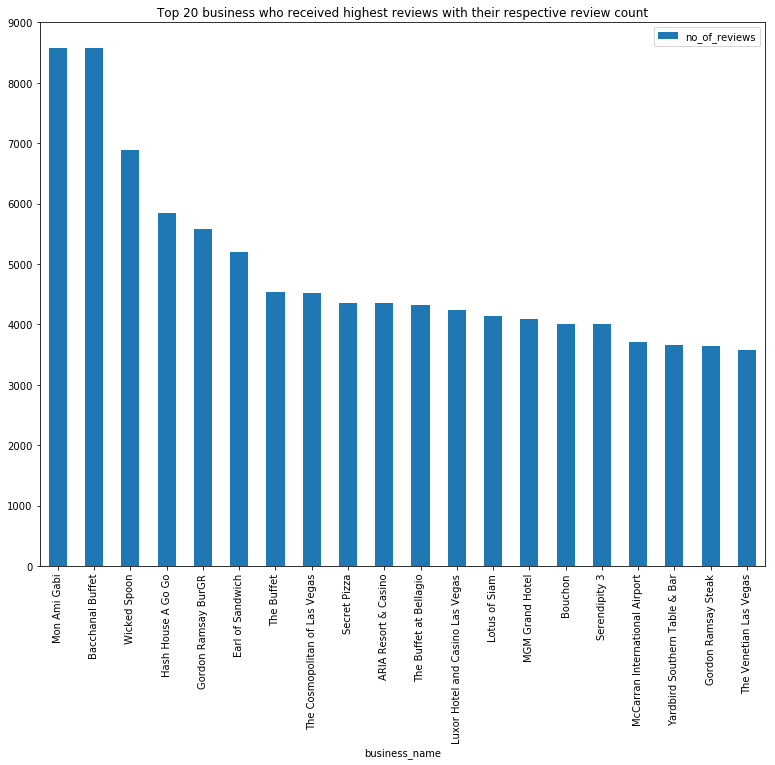

In [44]:
#Top 20 business who received highest reviews with their respective review count
top_20_businesses = sqlContext.sql(
'''SELECT b.business_id, name as business_name,  count(*) as no_of_reviews
FROM reviews r
JOIN businesses b
ON r.business_id = b.business_id
group by b.business_id, b.name
order by 3 desc
limit 20'''
).toPandas();
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(13)
top_20_businesses.plot(x='business_name', y='no_of_reviews', ax = ax, kind="bar")
plt.title('Top 20 business who received highest reviews with their respective review count')




<Figure size 432x288 with 0 Axes>

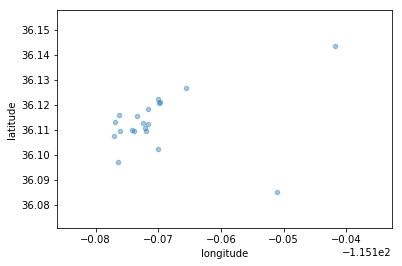

In [74]:
#Top 20 business locations map who received highest reviews 
top_20_businesses_locations = sqlContext.sql(
'''SELECT b.business_id, name as business_name, latitude, longitude, count(*) as no_of_reviews
FROM reviews r
JOIN businesses b
ON r.business_id = b.business_id
group by b.business_id, b.name, b.latitude, b.longitude
order by no_of_reviews desc
limit 20'''
).toPandas()
top_20_businesses_locations.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4)
plt.show()

In [103]:
#Moving average per month for each business
businesses_moving_avg_month = sqlContext.sql("""select business_id, month,avg(total_reviews)                                       
                                          over (partition by business_id, month order by month)
                                          as total
                                from (select business_id, month(date) as month, count(*) as total_reviews
                                from reviews
                                group by business_id, month(date)) r
                                order by business_id, month""")
businesses_moving_avg_month.show()

+--------------------+-----+-----+
|         business_id|month|total|
+--------------------+-----+-----+
|--1UhMGODdWsrMast...|    1|  1.0|
|--1UhMGODdWsrMast...|    2|  1.0|
|--1UhMGODdWsrMast...|    4|  3.0|
|--1UhMGODdWsrMast...|    5|  5.0|
|--1UhMGODdWsrMast...|    6|  5.0|
|--1UhMGODdWsrMast...|    7|  3.0|
|--1UhMGODdWsrMast...|    8|  3.0|
|--1UhMGODdWsrMast...|    9|  1.0|
|--1UhMGODdWsrMast...|   11|  1.0|
|--1UhMGODdWsrMast...|   12|  3.0|
|--6MefnULPED_I942...|    1|  6.0|
|--6MefnULPED_I942...|    2|  4.0|
|--6MefnULPED_I942...|    4|  2.0|
|--6MefnULPED_I942...|    5|  4.0|
|--6MefnULPED_I942...|    7|  4.0|
|--6MefnULPED_I942...|    8|  8.0|
|--6MefnULPED_I942...|    9|  4.0|
|--6MefnULPED_I942...|   10|  4.0|
|--6MefnULPED_I942...|   11|  4.0|
|--6MefnULPED_I942...|   12|  6.0|
+--------------------+-----+-----+
only showing top 20 rows



In [34]:
#Year over year changes in reviews for each 5 star business
business_yoy_reviews_comparision = sqlContext.sql("""select b.business_id, b.name as business_name, year(date) as year, r.stars, count(*) as total_reviews
from reviews r
join businesses b
on b.business_id = r.business_id
where r.stars>4
group by b.business_id, name, year(date), r.stars
order by b.business_id, year desc, total_reviews desc""")
business_yoy_reviews_comparision.show()


+--------------------+--------------------+----+-----+-------------+
|         business_id|       business_name|year|stars|total_reviews|
+--------------------+--------------------+----+-----+-------------+
|--6MefnULPED_I942...|John's Chinese BB...|2018|  5.0|            3|
|--6MefnULPED_I942...|John's Chinese BB...|2017|  5.0|            2|
|--6MefnULPED_I942...|John's Chinese BB...|2016|  5.0|            2|
|--6MefnULPED_I942...|John's Chinese BB...|2015|  5.0|            1|
|--6MefnULPED_I942...|John's Chinese BB...|2008|  5.0|            1|
|--7zmmkVg-IMGaXbu...|      Primal Brewery|2018|  5.0|            7|
|--7zmmkVg-IMGaXbu...|      Primal Brewery|2017|  5.0|            6|
|--7zmmkVg-IMGaXbu...|      Primal Brewery|2016|  5.0|            7|
|--7zmmkVg-IMGaXbu...|      Primal Brewery|2015|  5.0|            5|
|--8LPVSo5i0Oo61X0...|Valley Bone and J...|2017|  5.0|            1|
|--8LPVSo5i0Oo61X0...|Valley Bone and J...|2014|  5.0|            1|
|--9QQLMTbFzLJ_oT-...|         Gre

In [108]:
#Total reviews received by a business 
business_yoy_reviews_comparision = sqlContext.sql("""select b.business_id, b.name as business_name, year(date) as year, r.stars, count(*) as total_reviews
from reviews r
join businesses b
on b.business_id = r.business_id
where r.stars>4 and r.business_id like 'vHz2RLtfUMVRPFmd7%'
group by b.business_id, name, year(date), r.stars
order by year desc, total_reviews desc""")
business_yoy_reviews_comparision.show()

+--------------------+--------------------+----+-----+-------------+
|         business_id|       business_name|year|stars|total_reviews|
+--------------------+--------------------+----+-----+-------------+
|vHz2RLtfUMVRPFmd7...|Gordon Ramsay Hel...|2018|  5.0|         1396|
+--------------------+--------------------+----+-----+-------------+



In [116]:
#Fetch current day in python 
d = datetime.datetime.today()
day_dic={0:'Sunday',1:'Monday',2:'Tuesday',3:'Wednesday',4:'Thursday',5:'Friday',6:'Saturday',}

print(day_dic.get(int(d.strftime("%w"))))

Tuesday


In [131]:
#Fetch hours information for Friday
business_hours = sqlContext.sql("""select business_id, split(hours.Friday, '-') from businesses where split(hours.Friday, '-')[0] is not null""")
business_hours.show()

+--------------------+----------------------------------+
|         business_id|split(hours.Friday AS `Friday`, -)|
+--------------------+----------------------------------+
|QXAEGFB4oINsVuTFx...|                        [9:0, 1:0]|
|gnKjwL_1w79qoiV3I...|                     [17:30, 22:0]|
|xvX2CttrVhyG2z1dF...|                       [8:0, 17:0]|
|HhyxOkGAM07SRYtlQ...|                       [7:0, 23:0]|
|68dUKd8_8liJ7in4a...|                       [9:0, 19:0]|
|gbQN7vr_caG_A1ugS...|                      [10:0, 19:0]|
|Y6iyemLX_oylRpnr3...|                      [10:0, 17:0]|
|4GBVPIYRvzGh4K4Tk...|                       [9:0, 19:0]|
|fcXOEZdXYeZqnQ3lG...|                       [9:0, 17:0]|
|1Dfx3zM-rW4n-31Ke...|                        [7:0, 1:0]|
|5t3KVdMnFgAYmSl1w...|                       [10:0, 1:0]|
|fweCYi8FmbJXHCqLn...|                       [10:0, 1:0]|
|-K4gAv8_vjx8-2Bxk...|                      [11:0, 17:0]|
|A98xW4qb7vOTguggH...|                     [16:0, 21:30]|
|giC3pVVFxCRR8

In [155]:
#Select all business names which are open on Friday from 6 to 12 Midnight
business_hours = sqlContext.sql("""select b.*, stars, total_reviews from 
(select business_id, name as business_name, latitude, longitude, hours.Friday
from businesses
where int(split(split(hours.Friday, '-')[0], ':')[0]) < 6 and int(split(split(hours.Friday, '-')[0], ':')[1]) <= 0
and int(split(split(hours.Friday, '-')[1], ':')[0]) >= 0) b
join (select business_id, stars, count(*) as total_reviews from reviews where stars > 4 group by business_id, stars) r
on b.business_id = r.business_id
order by total_reviews desc""")
business_hours.show()

+--------------------+--------------------+-------------+---------------+--------+-----+-------------+
|         business_id|       business_name|     latitude|      longitude|  Friday|stars|total_reviews|
+--------------------+--------------------+-------------+---------------+--------+-----+-------------+
|DkYS3arLOhA8si5uU...|    Earl of Sandwich|    36.109418|   -115.1718738| 0:0-0:0|  5.0|         2645|
|f4x1YBxkLrZg652xt...|  Hash House A Go Go|36.1181806906|-115.1715797813| 0:0-0:0|  5.0|         2382|
|5LNZ67Yw9RD6nf4_U...|The Cosmopolitan ...|   36.1097553|   -115.1738769| 0:0-0:0|  5.0|         2056|
|JDZ6_yycNQFTpUZzL...|   El Dorado Cantina|36.1349154274|-115.1758220047| 0:0-0:0|  5.0|         1966|
|awI4hHMfa7H0Xf0-C...|      The Oyster Bar|36.1431362393|-115.1747075477| 0:0-0:0|  5.0|         1621|
|Wxxvi3LZbHNIDwJ-Z...|The Venetian Las ...|    36.121189|    -115.169657| 0:0-0:0|  5.0|         1563|
|t-o_Sraneime4DDhW...|      Wynn Las Vegas|    36.127684|    -115.165905|

In [25]:
#Fetch categories from businesses
categories = sqlContext.sql("""select distinct explode(split(categories, ',')) from businesses""")
categories.show(1000, False)

+-----------------------------------+
|col                                |
+-----------------------------------+
| Furniture Stores                  |
| Korean                            |
|Dermatologists                     |
| Boudoir Photography               |
|Hot Air Balloons                   |
|Paddleboarding                     |
|Historical Tours                   |
|Mobile Home Dealers                |
| Beach Equipment Rentals           |
| Tires                             |
| Car Window Tinting                |
|Fondue                             |
|Pet Waste Removal                  |
| Commercial Truck Repair           |
| Live/Raw Food                     |
|Skating Rinks                      |
| Hakka                             |
| Historical Tours                  |
|Pet Photography                    |
|Data Recovery                      |
|Videographers                      |
|Aerial Tours                       |
|Beaches                            |
|Boat Repair

In [27]:
#Reviews for each category 
categories_reviews = sqlContext.sql("""
select name as business_name, review_count, explode(split(categories, ',')) from businesses
order by review_count desc
limit 30
""")
categories_reviews.show(30,False)

+-------------------+------------+--------------------------+
|business_name      |review_count|col                       |
+-------------------+------------+--------------------------+
|Mon Ami Gabi       |8348        |Food                      |
|Mon Ami Gabi       |8348        | French                   |
|Mon Ami Gabi       |8348        | Breakfast & Brunch       |
|Mon Ami Gabi       |8348        | Restaurants              |
|Mon Ami Gabi       |8348        | Steakhouses              |
|Bacchanal Buffet   |8339        |Restaurants               |
|Bacchanal Buffet   |8339        | Buffets                  |
|Bacchanal Buffet   |8339        | Sandwiches               |
|Bacchanal Buffet   |8339        | Food                     |
|Bacchanal Buffet   |8339        | Breakfast & Brunch       |
|Wicked Spoon       |6708        | Breakfast & Brunch       |
|Wicked Spoon       |6708        | Restaurants              |
|Wicked Spoon       |6708        |Buffets                   |
|Hash Ho

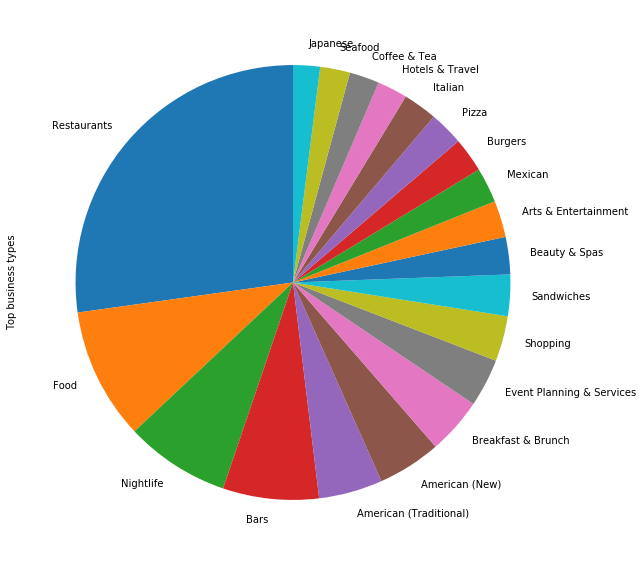

In [46]:
# Business categories which are top reviewed
categories_reviews = sqlContext.sql(""" select trim(categories) as categories, sum(review_count) as review_count from
(select business_id, name as business_name, review_count as review_count, explode(split(categories, ',')) as categories
from businesses) b
group by trim(categories)
order by review_count desc
limit 20
""").toPandas()
x_val=categories_reviews["review_count"].values
labels=categories_reviews["categories"].values
series = pd.Series(x_val, index=labels, name='Top business types')
series.plot.pie(figsize=(10, 10),startangle=90)

In [48]:
# Business categories which need improvements
categories_reviews = sqlContext.sql(""" select business_name, trim(categories) as categories, sum(review_count) as review_count from
(select business_id, name as business_name, review_count as review_count, explode(split(categories, ',')) as categories
from businesses) b
group by business_name, trim(categories)
order by review_count
limit 20
""")
categories_reviews.show()

+--------------------+--------------------+------------+
|       business_name|          categories|review_count|
+--------------------+--------------------+------------+
|      Twirl Boutique|              Bridal|           3|
|Ansarian Dental C...|   Cosmetic Dentists|           3|
|  D Nail Salon & Spa|         Nail Salons|           3|
|  Davidson Law Group|     Real Estate Law|           3|
|    Royal Auto Group|         Auto Repair|           3|
| Foote's Valley Farm|Arts & Entertainment|           3|
|         YYC repairs|      Local Services|           3|
|Ccs Presentation ...|High Fidelity Aud...|           3|
|         Rolling Wok|         Ethnic Food|           3|
|Rembrandt Constru...|         Contractors|           3|
|Marché des Possibles|Community Service...|           3|
|My Cheesecake Add...|            Desserts|           3|
|     Kitchen Gourmet|       Home & Garden|           3|
|The Golden Orient...|             Dim Sum|           3|
|   Woodbridge Vacuum|         

In [56]:
#Highly complimented latest 5 tips & the user details who had given tips for 5 star business 
tips_business = sqlContext.sql(""" select * from
(select b.name as business_name, text, compliment_count, u.name as user_name, t.date, 
DENSE_RANK() OVER(PARTITION BY t.business_id order by t.date desc, compliment_count desc)AS r
from tips t
join businesses b
on b.business_id = t.business_id
join users u
on t.user_id = u.user_id)temp
where temp.r<=5
order by business_name, date desc, compliment_count desc
""")
tips_business.show(100,False)

+---------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------+-----------+-------------------+---+
|business_name                    |text                                                                                                                                                                                                                                                                                                                                                                                         |compliment_count|user_name  |date               |r  |
+---------------------------------+-----------------------

In [54]:
#Tips who has received atleast 1 compliment
sqlContext.sql("""select * from tips where compliment_count > 0""").show(100, False)

+----------------------+----------------+-------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------+
|business_id           |compliment_count|date               |text                                                                                                                                                                                                                                                                                                                                                                                                

In [59]:
#Users & theirs friends
sqlContext.sql("""select user_id, fans, explode(split(friends, ',')) as friends from users""").show(10, False)

+----------------------+----+-----------------------+
|user_id               |fans|friends                |
+----------------------+----+-----------------------+
|l6BmjZMeQD3rDxWUbiAiow|5   |c78V-rj8NQcQjOI8KP3UEA |
|l6BmjZMeQD3rDxWUbiAiow|5   | alRMgPcngYSCJ5naFRBz5g|
|l6BmjZMeQD3rDxWUbiAiow|5   | ajcnq75Z5xxkvUSmmJ1bCg|
|l6BmjZMeQD3rDxWUbiAiow|5   | BSMAmp2-wMzCkhTfq9ToNg|
|l6BmjZMeQD3rDxWUbiAiow|5   | jka10dk9ygX76hJG0gfPZQ|
|l6BmjZMeQD3rDxWUbiAiow|5   | dut0e4xvme7QSlesOycHQA|
|l6BmjZMeQD3rDxWUbiAiow|5   | l4l5lBnK356zBua7B-UJ6Q|
|l6BmjZMeQD3rDxWUbiAiow|5   | 0HicMOOs-M_gl2eO-zES4Q|
|l6BmjZMeQD3rDxWUbiAiow|5   | _uI57wL2fLyftrcSFpfSGQ|
|l6BmjZMeQD3rDxWUbiAiow|5   | T4_Qd0YWbC3co6WSMw4vxg|
+----------------------+----+-----------------------+
only showing top 10 rows



In [9]:
#User details who had given maximum reviews
user_reviews = sqlContext.sql("""select u.name as user_name, total_reviews, fans, friends, size(split(friends, ',')) as total_friends
from users u
join (select user_id, count(*) as total_reviews from reviews group by user_id)r
on u.user_id = r.user_id
order by total_reviews desc""")
user_reviews.show(10,False)


+---------+-------------+----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

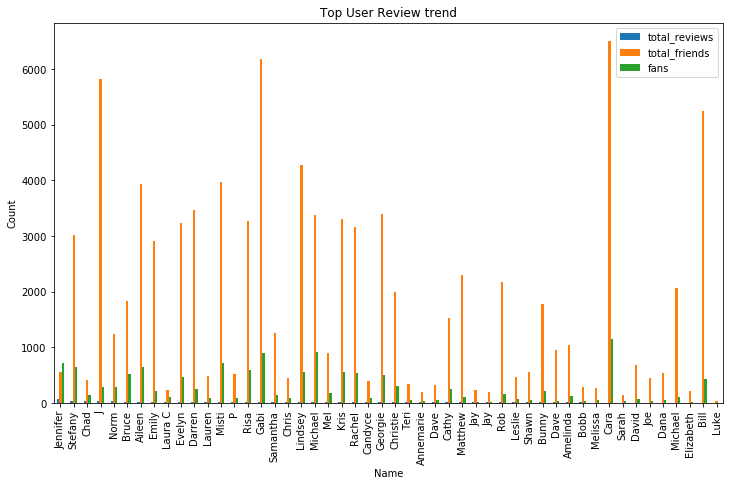

In [15]:
#relation between users, total reviews by that user, total friend the user has & fans the used have
user_reviews = sqlContext.sql("""select u.name as user_name, total_reviews, fans, friends, size(split(friends, ',')) as total_friends
from users u
join (select user_id, count(*) as total_reviews from reviews group by user_id)r
on u.user_id = r.user_id
order by total_reviews desc limit 50""").toPandas()
axes = user_reviews.plot(x="user_name", y=["total_reviews", "total_friends", "fans"],
                           kind="bar",figsize=(12, 7))
plt.xlabel('Name', axes=axes)
plt.ylabel('Count', axes=axes)
plt.title('Top User Review trend', axes=axes)
plt.show()

In [19]:
#select all business & their categories which don't have a single photo
categories_missing_photos = sqlContext.sql("""select b.business_id, business_name, trim(b.categories)
from (select business_id, name as business_name, explode(split(categories, ',')) as categories from businesses ) b
left join photos p
on b.business_id = p.business_id and trim(b.categories)=trim(p.label)
where p.label is null""")
categories_missing_photos.show(30,False)

+----------------------+---------------------------------+-------------------------+
|business_id           |business_name                    |trim(categories)         |
+----------------------+---------------------------------+-------------------------+
|--DdmeR16TRb3LsjG0ejrQ|World Food Championships         |Festivals                |
|--I7YYLada0tSLkORTHb5Q|Happy Moose Bar and Grill        |Nightlife                |
|--VMPfs4zfZJtQbqzJsNhg|Charlotte Root Canal Center      |Health & Medical         |
|-0NrB58jqKqJfuUCDupcsw|The Fry                          |Food                     |
|-1CI4H3DLkI-NdWLbIae6g|Benny&Co.                        |Chicken Wings            |
|-37_L44VjFw1U4tBfBDHRw|Cloud Nine Wellness Spa          |Massage Therapy          |
|-3Haoc0l9DZRSXxIHi9oJg|Klondike                         |Italian                  |
|-3iRcdd9CPD5mqQj8q5jXQ|The Nite Owl Barber Shop         |Beauty & Spas            |
|-5brzniWtye3w__aEvCaAA|Palermos Pizza                   |Sports 

In [20]:
#Select information from photos for a given business id (To make sure above data is correct)
sqlContext.sql("""select * from photos where business_id='DdmeR16TRb3LsjG0ejrQ' """).show()

+-----------+-------+-----+--------+
|business_id|caption|label|photo_id|
+-----------+-------+-----+--------+
+-----------+-------+-----+--------+



In [38]:
#buisness and number of checkins
sqlContext.sql("""select business_id, count(checkin_date) as no_checkin_year from
(select business_id, explode(split(date, ',')) as checkin_date from checkins) c
group by business_id""").show(20, False)

+----------------------+---------------+
|business_id           |no_checkin_year|
+----------------------+---------------+
|--9e1ONYQuAa-CB_Rrw7Tw|2770           |
|-6c_bJblLXUwoWfmYLtH_w|7              |
|-ElDqujEn1u64ynQr0bX7g|2              |
|-Gh9a15ijNii-8rnp4x3xA|1              |
|-I06hkMFrX0KBqu61ik1YA|39             |
|-TGwtTiieh_JLml5_VRMQA|54             |
|-VAsjhmAbKF3Pb_-8rh3xg|31             |
|-cxD1NimFldATDUsN-oa3A|101            |
|-m8v19CXrGEYr3PALjqVCg|24             |
|-qL-wX-UuMaHDBA2X5G4kw|66             |
|-r8SvItXXG6_T3mP5GXRAw|19             |
|069TWjwxctY-3X_TitxJKQ|503            |
|0859wfd1BQHG46Zpwhc0ZQ|787            |
|09OYbFNrS1n8u5gE6W9ItA|43             |
|09p3b5BCSz2FPvgR-8xz3A|5              |
|0DwMrcy7_X_C_mP8_QcXug|8              |
|0FWYa5RT_gQOwW3CRvrZow|10             |
|0XF5tnQeSZO8BG6OErfK3Q|25             |
|0bqV9uzFVz98Bn_RImcJTg|401            |
|0owIRP_z5RcYKKmh5RnD7A|8              |
+----------------------+---------------+
only showing top

In [28]:
#Business & their checkin dates
sqlContext.sql("""select business_id, explode(split(date, ',')) as checkin_date from checkins where business_id = '09p3b5BCSz2FPvgR-8xz3A'""").show(20, False)

+----------------------+--------------------+
|business_id           |checkin_date        |
+----------------------+--------------------+
|09p3b5BCSz2FPvgR-8xz3A|2010-12-07 02:55:31 |
|09p3b5BCSz2FPvgR-8xz3A| 2011-01-03 04:26:35|
|09p3b5BCSz2FPvgR-8xz3A| 2012-12-07 23:45:03|
|09p3b5BCSz2FPvgR-8xz3A| 2012-12-08 17:59:30|
|09p3b5BCSz2FPvgR-8xz3A| 2016-03-08 20:55:45|
+----------------------+--------------------+

